In [ ]:
from google.colab import drive
drive.mount('/content/d')

Mounted at /content/d


**Probem set:** In this example we have the database of the public appeals (RUS) devided by categories. The task is to classify the upcoming appeals based on the text within.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, BatchNormalization, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv('d/My Drive/nn/_4/clean_data.csv')
df = df.iloc[:, :2]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10059 entries, 0 to 10058
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10059 non-null  object
 1   category  8262 non-null   object
dtypes: object(2)
memory usage: 157.3+ KB
None


In [ ]:
for cat in df.category.unique():
    print(
        f'the number of records in category {cat}: '
        f'{df[df.category == cat].shape[0]}'
    )

the number of records in category Дороги и транспорт: 1411
the number of records in category ЖКХ: 2063
the number of records in category Строительство: 349
the number of records in category Спорт: 246
the number of records in category Благо­­устрой­­ство: 1686
the number of records in category Образование и наука: 290
the number of records in category Культура: 100
the number of records in category Демография: 20
the number of records in category Социальная сфера: 370
the number of records in category Другое: 208
the number of records in category Бизнес: 187
the number of records in category Здравоохранение: 368
the number of records in category Органы власти: 244
the number of records in category Экология: 180
the number of records in category Правопорядок: 172
the number of records in category Труд и занятость населения: 151
the number of records in category Борьба с коррупцией: 59
the number of records in category Промышленность: 13
the number of records in category Сельское хозяйст

**STEP 0:** extract texts and labels

Simple step to extract the required data:

In [ ]:
texts = df.text.values # extract the texts (-> features)
labels = list(df.category.values) # -> labels
nLabels = df.category.nunique() + 1 # number of categories

**STEP 1:** convert the text to the *Bags Of Words*

We need to split our texts into the single words array and fit the tokenizer based on it. The next step to convert the resulting indices into the boolean matrix alike Bag of Words format. This can be performed with method *sequences_to_matrix*:

In [ ]:
# all the symbols to exclude from the processed text
symbolsToFilter = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
maxWordsCount = 60000 # max words to be processed by the model

tokenizer = Tokenizer(
    num_words = maxWordsCount, 
    filters = symbolsToFilter, 
    lower = True, # enforce the lower register
    split = ' ', # split by space
    oov_token = 'unknown', # replaces all out-of-vocabulary words
    char_level = False # if True, every charcter is used as token
)

tokenizer.fit_on_texts(texts)
xAll = tokenizer.texts_to_matrix(texts)

print(f'the vocabulary size: {len(tokenizer.word_index.items())}')
print(xAll.shape)

the vocabulary size: 80594
(10059, 60000)


The text is processed, now we need to encode the labels. To do that we'll apply [LabelEncoder()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) from scikit-learn tools and *utils.to_categorical*. The steps will be: 

text -> integer code -> binary matrix

In [ ]:
encoder = LabelEncoder()
encoder.fit(labels)
labelsEncoded = encoder.transform(labels)
yAll = utils.to_categorical(labelsEncoded, len(set(labels)))

print(f'labels encoded shape: {labelsEncoded.shape}')
print('the example of the encoded labels:')
print(labelsEncoded[:20])
print('the example of the binary label form:')
print(yAll[0])
print(yAll.shape)

labels encoded shape: (10059,)
the example of the encoded labels:
[ 5  7 18 17  5  5  5  5  2  5 17  5 17 11 18  7  2 10  7  5]
the example of the binary label form:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(10059, 22)


Now let's prepare the input for the model and prepare the train and test samples:

In [ ]:
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2)
print(f'the shapes are: {xTrain.shape, yTrain.shape, xVal.shape, yVal.shape}')

the shapes are: ((8047, 60000), (8047, 22), (2012, 60000), (2012, 22))


Now let's build the model up. We set 3 dense layers with the dropout. The activation functions are *ReLU (rectified linear unit)* for the input and hidden layers + *softmax* for the output layer. The loss function is *categorical crossentropy*. 

Epoch 1/20
63/63 [==============================] - 3s 22ms/step - loss: 2.4657 - accuracy: 0.2238 - val_loss: 1.9505 - val_accuracy: 0.4374
Epoch 2/20
63/63 [==============================] - 1s 14ms/step - loss: 1.8114 - accuracy: 0.4251 - val_loss: 1.7003 - val_accuracy: 0.4766
Epoch 3/20
63/63 [==============================] - 1s 14ms/step - loss: 1.4101 - accuracy: 0.5487 - val_loss: 1.6257 - val_accuracy: 0.5104
Epoch 4/20
63/63 [==============================] - 1s 14ms/step - loss: 1.0838 - accuracy: 0.6640 - val_loss: 1.6460 - val_accuracy: 0.5422
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 0.8525 - accuracy: 0.7457 - val_loss: 1.7635 - val_accuracy: 0.5427
Epoch 6/20
63/63 [==============================] - 1s 15ms/step - loss: 0.6694 - accuracy: 0.8023 - val_loss: 1.8568 - val_accuracy: 0.5353
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 0.5646 - accuracy: 0.8336 - val_loss: 1.9468 - val_accuracy: 0.5507
Epoch 8/20
63

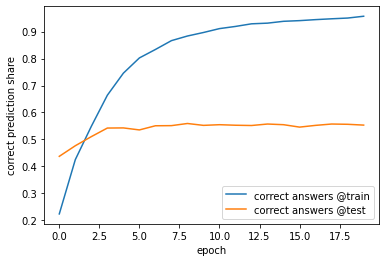

In [ ]:
modelD = Sequential()
modelD.add(Dense(
    100, 
    input_dim = maxWordsCount,
    activation = 'relu'
))
modelD.add(Dropout(0.4))
modelD.add(Dense(100, activation='relu'))
modelD.add(Dropout(0.4))
modelD.add(Dense(100, activation='relu'))
modelD.add(Dropout(0.4))
modelD.add(Dense(len(set(labels)), activation='softmax'))

modelD.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = modelD.fit(
    xTrain, yTrain,
    epochs=20,
    batch_size=128,
    validation_data = (xVal, yVal)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

The score is quite low (54% @ validation). Let's try the *Embedding* layer. To do that:
1. transfrom text to sequences with [tf.keras.preprocessing.text.Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)
2. tranfrom the resulting sequences to **the** 2D arrays with the funtion [tf.keras.preprocessing.sequence.pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [ ]:
maxLen = 400

Sequences = tokenizer.texts_to_sequences(texts)
npSequences = np.array(Sequences, dtype=object)

xTrainE, xValE, yTrainE, yValE = train_test_split(npSequences, yAll, test_size=0.2)

xTrainE = pad_sequences(xTrainE, maxlen=maxLen, padding='pre', truncating='pre')
xValE = pad_sequences(xValE, maxlen=maxLen, padding='pre', truncating='pre')

In [ ]:
print(f'the shapes are: {xTrainE.shape, yTrainE.shape, xValE.shape, yValE.shape}')

the shapes are: ((8047, 400), (8047, 22), (2012, 400), (2012, 22))


Pass the prerocessed data to the model:

Epoch 1/20
161/161 [==============================] - 5s 26ms/step - loss: 3.2538 - accuracy: 0.1163 - val_loss: 2.6557 - val_accuracy: 0.1928
Epoch 2/20
161/161 [==============================] - 4s 25ms/step - loss: 2.2862 - accuracy: 0.3335 - val_loss: 2.4086 - val_accuracy: 0.1998
Epoch 3/20
161/161 [==============================] - 4s 24ms/step - loss: 1.2813 - accuracy: 0.6404 - val_loss: 2.1985 - val_accuracy: 0.2947
Epoch 4/20
161/161 [==============================] - 4s 24ms/step - loss: 0.7692 - accuracy: 0.7966 - val_loss: 2.0550 - val_accuracy: 0.3912
Epoch 5/20
161/161 [==============================] - 4s 24ms/step - loss: 0.4866 - accuracy: 0.8811 - val_loss: 2.0220 - val_accuracy: 0.4031
Epoch 6/20
161/161 [==============================] - 4s 24ms/step - loss: 0.3237 - accuracy: 0.9247 - val_loss: 2.1077 - val_accuracy: 0.4180
Epoch 7/20
161/161 [==============================] - 4s 24ms/step - loss: 0.2408 - accuracy: 0.9458 - val_loss: 2.1554 - val_accuracy: 0.4125

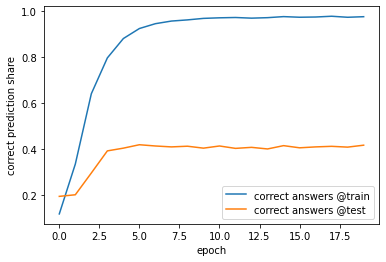

In [ ]:
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 50, input_length=maxLen))
modelE.add(SpatialDropout1D(0.4))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(64, activation='relu'))
modelE.add(Dropout(0.4))
modelE.add(BatchNormalization())
modelE.add(Dense(len(set(labels)), activation='softmax'))

modelE.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = modelE.fit(
    xTrainE, yTrainE,
    epochs = 20,
    batch_size = 50,
    validation_data = (xValE, yValE)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

The result with the Embedding layer is even worser. Therefore we can try to filter the text and the raw texts at first:

1. Set the minimum and max number of text lines corresponding to each 
2. Drop the empty lines


In [ ]:
minCountStrings, maxCountStrings = 300, 400
df = df.dropna().reset_index()

for label in df.category.unique():
    initLen = df[df.category == label].shape[0]
    if df[df.category == label].shape[0] < minCountStrings:
        df = df.drop(df[df.category == label].index)
    if df[df.category == label].shape[0] > maxCountStrings:
        df = df.drop(df[df.category == label].index[maxCountStrings:])
    print(f'Total records of label {label} : {initLen}, collected: {df[df.category == label].shape[0]}')

df = df.reset_index()

Total records of label Дороги и транспорт : 1411, collected: 400
Total records of label ЖКХ : 2063, collected: 400
Total records of label Строительство : 349, collected: 349
Total records of label Спорт : 246, collected: 0
Total records of label Благо­­устрой­­ство : 1686, collected: 400
Total records of label Образование и наука : 290, collected: 0
Total records of label Культура : 100, collected: 0
Total records of label Демография : 20, collected: 0
Total records of label Социальная сфера : 370, collected: 370
Total records of label Другое : 208, collected: 0
Total records of label Бизнес : 187, collected: 0
Total records of label Здравоохранение : 368, collected: 368
Total records of label Органы власти : 244, collected: 0
Total records of label Экология : 180, collected: 0
Total records of label Правопорядок : 172, collected: 0
Total records of label Труд и занятость населения : 151, collected: 0
Total records of label Борьба с коррупцией : 59, collected: 0
Total records of label 

the shapes are: ((1829, 60000), (1829, 6), (458, 60000), (458, 6))
Epoch 1/20
15/15 [==============================] - 1s 28ms/step - loss: 1.7622 - accuracy: 0.2411 - val_loss: 1.6631 - val_accuracy: 0.4738
Epoch 2/20
15/15 [==============================] - 0s 15ms/step - loss: 1.5509 - accuracy: 0.4461 - val_loss: 1.3154 - val_accuracy: 0.7052
Epoch 3/20
15/15 [==============================] - 0s 15ms/step - loss: 1.1768 - accuracy: 0.6178 - val_loss: 0.9953 - val_accuracy: 0.6943
Epoch 4/20
15/15 [==============================] - 0s 15ms/step - loss: 0.7751 - accuracy: 0.7682 - val_loss: 0.7917 - val_accuracy: 0.7533
Epoch 5/20
15/15 [==============================] - 0s 14ms/step - loss: 0.4928 - accuracy: 0.8595 - val_loss: 0.7497 - val_accuracy: 0.7576
Epoch 6/20
15/15 [==============================] - 0s 15ms/step - loss: 0.2813 - accuracy: 0.9317 - val_loss: 0.8038 - val_accuracy: 0.7533
Epoch 7/20
15/15 [==============================] - 0s 15ms/step - loss: 0.1705 - accur

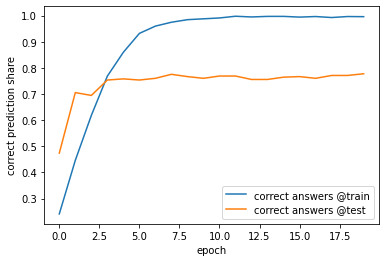

In [ ]:
texts = df.text.values
labels = list(df.category.values)
nLabels = df.category.nunique() + 1

maxWordsCount = 60000 

tokenizer = Tokenizer(
    num_words = maxWordsCount, 
    filters = symbolsToFilter, 
    lower = True, 
    split = ' ', 
    oov_token = 'unknown', 
    char_level = False 
)

tokenizer.fit_on_texts(texts)
xAll = tokenizer.texts_to_matrix(texts)

encoder = LabelEncoder()
encoder.fit(labels)
labelsEncoded = encoder.transform(labels)
yAll = utils.to_categorical(labelsEncoded, len(set(labels)))

xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2)
print(f'the shapes are: {xTrain.shape, yTrain.shape, xVal.shape, yVal.shape}')

modelD = Sequential()
modelD.add(Dense(
    100, 
    input_dim = maxWordsCount,
    activation = 'relu'
))
modelD.add(Dropout(0.4))
modelD.add(Dense(100, activation='relu'))
modelD.add(Dropout(0.4))
modelD.add(Dense(100, activation='relu'))
modelD.add(Dropout(0.4))
modelD.add(Dense(len(set(labels)), activation='softmax'))

modelD.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = modelD.fit(
    xTrain, yTrain,
    epochs=20,
    batch_size=128,
    validation_data = (xVal, yVal)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

With the raw text filtered we managed to increase the score up to 82%. Let's check if it works for the embedding layer:

the shapes are: ((1829, 400), (1829, 6), (458, 400), (458, 6))
Epoch 1/20
37/37 [==============================] - 2s 28ms/step - loss: 2.3080 - accuracy: 0.1815 - val_loss: 1.8144 - val_accuracy: 0.1747
Epoch 2/20
37/37 [==============================] - 1s 23ms/step - loss: 1.8910 - accuracy: 0.2679 - val_loss: 1.8346 - val_accuracy: 0.1747
Epoch 3/20
37/37 [==============================] - 1s 23ms/step - loss: 1.4895 - accuracy: 0.4084 - val_loss: 1.8463 - val_accuracy: 0.1747
Epoch 4/20
37/37 [==============================] - 1s 23ms/step - loss: 0.6825 - accuracy: 0.7950 - val_loss: 1.7870 - val_accuracy: 0.2598
Epoch 5/20
37/37 [==============================] - 1s 24ms/step - loss: 0.3628 - accuracy: 0.9158 - val_loss: 1.7654 - val_accuracy: 0.2664
Epoch 6/20
37/37 [==============================] - 1s 23ms/step - loss: 0.2032 - accuracy: 0.9716 - val_loss: 1.7448 - val_accuracy: 0.2162
Epoch 7/20
37/37 [==============================] - 1s 24ms/step - loss: 0.1369 - accuracy:

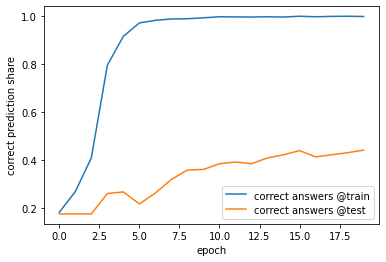

In [ ]:
npSequences = np.array(tokenizer.texts_to_sequences(texts), dtype=object)
xTrainE, xValE, yTrainE, yValE = train_test_split(npSequences, yAll, test_size=0.2)

xTrainE = pad_sequences(xTrainE, maxlen=maxLen, padding='pre', truncating='pre')
xValE = pad_sequences(xValE, maxlen=maxLen, padding='pre', truncating='pre')

print(f'the shapes are: {xTrainE.shape, yTrainE.shape, xValE.shape, yValE.shape}')

modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 50, input_length=maxLen))
modelE.add(SpatialDropout1D(0.4))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(64, activation='relu'))
modelE.add(Dropout(0.4))
modelE.add(BatchNormalization())
modelE.add(Dense(len(set(labels)), activation='softmax'))

modelE.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = modelE.fit(
    xTrainE, yTrainE,
    epochs = 20,
    batch_size = 50,
    validation_data = (xValE, yValE)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

In this case and under this structure the dense model with the embedding layer is still a bad idea, the score is lower than 50%.

Let's try another approcah - we slice our train sample in the following way:

1. Get the array of the word indices (*wordIndices*)
2. Cut the sample with the given length (*xLen*)
3. Dump it to the container
4. Take a step from the begining of the previous sample (*step*)

In [ ]:
df = pd.read_csv('d/My Drive/nn/_4/clean_data.csv')
df = df.iloc[:, :2]


minCountStrings, maxCountStrings = 300, 400
df = df.dropna().reset_index()

for label in df.category.unique():
    initLen = df[df.category == label].shape[0]
    if df[df.category == label].shape[0] < minCountStrings:
        df = df.drop(df[df.category == label].index)
    if df[df.category == label].shape[0] > maxCountStrings:
        df = df.drop(df[df.category == label].index[maxCountStrings:])
    print(f'Total records of label {label} : {initLen}, collected: {df[df.category == label].shape[0]}')

df = df.reset_index()

texts = df.text.values
labels = list(df.category.values)
nLabels = df.category.nunique() + 1

maxWordsCount = 50000

symbolsToFilter = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
tokenizer = Tokenizer(
    num_words = maxWordsCount,
    filters = symbolsToFilter,
    lower = True,
    split = ' ',
    oov_token = 'unknown',
    char_level = False
)

tokenizer.fit_on_texts(texts)

encoder = LabelEncoder()
encoder.fit(labels)
labelsEncoded = encoder.transform(labels)
yAll = utils.to_categorical(labelsEncoded, len(set(labels)))

Total records of label Дороги и транспорт : 1411, collected: 400
Total records of label ЖКХ : 2063, collected: 400
Total records of label Строительство : 349, collected: 349
Total records of label Спорт : 246, collected: 0
Total records of label Благо­­устрой­­ство : 1686, collected: 400
Total records of label Образование и наука : 290, collected: 0
Total records of label Культура : 100, collected: 0
Total records of label Демография : 20, collected: 0
Total records of label Социальная сфера : 370, collected: 370
Total records of label Другое : 208, collected: 0
Total records of label Бизнес : 187, collected: 0
Total records of label Здравоохранение : 368, collected: 368
Total records of label Органы власти : 244, collected: 0
Total records of label Экология : 180, collected: 0
Total records of label Правопорядок : 172, collected: 0
Total records of label Труд и занятость населения : 151, collected: 0
Total records of label Борьба с коррупцией : 59, collected: 0
Total records of label 

In [ ]:
def getSetFromIndices(wordIndices, xLen, step):
    xSample = []
    wordsLen = len(wordIndices)
    index = 0

    while (index + xLen <= wordsLen):
        xSample.append(wordIndices[index : index+ xLen])
        index += step

    return xSample

def createSetsMultiClasses(wordIndices, xLen, step):
    nLabels = len(wordIndices)
    classesXSamples = []
    for wIdx in wordIndices:
        # print(wIdx)
        classesXSamples.append(getSetFromIndices(wIdx, xLen, step))
    
    xSamples, ySamples = [], []
    for l in range(nLabels):
        xL = classesXSamples[l]
        for i in range(len(xL)):
            xSamples.append(xL[i])
            ySamples.append(yAll[l])

    xSamples, ySamples = np.array(xSamples), np.array(ySamples)

    return (xSamples, ySamples)

wordIndices = tokenizer.texts_to_sequences(texts)

xTrainI, xValI, yTrain, yVal = train_test_split(wordIndices, yAll, test_size=0.3)

xLen = 50
step = 10
xTrain, yTrain = createSetsMultiClasses(xTrainI, xLen, step)
xVal, yVal = createSetsMultiClasses(xValI, xLen, step)

print(xTrain.shape, yTrain.shape)
print(xVal.shape, yVal.shape)

xTrainB = tokenizer.sequences_to_matrix(xTrain.tolist())
xValB = tokenizer.sequences_to_matrix(xVal.tolist())

print(xTrainB.shape, yTrain.shape)
print(xValB.shape, yVal.shape)

(16171, 50) (16171, 6)
(7285, 50) (7285, 6)
(16171, 50000) (16171, 6)
(7285, 50000) (7285, 6)


Epoch 1/20
127/127 [==============================] - 3s 20ms/step - loss: 1.1918 - accuracy: 0.5366 - val_loss: 2.7548 - val_accuracy: 0.2166
Epoch 2/20
127/127 [==============================] - 2s 14ms/step - loss: 0.1692 - accuracy: 0.9523 - val_loss: 3.4064 - val_accuracy: 0.2048
Epoch 3/20
127/127 [==============================] - 2s 14ms/step - loss: 0.0698 - accuracy: 0.9789 - val_loss: 3.7043 - val_accuracy: 0.2194
Epoch 4/20
127/127 [==============================] - 2s 14ms/step - loss: 0.0491 - accuracy: 0.9838 - val_loss: 3.9332 - val_accuracy: 0.2070
Epoch 5/20
127/127 [==============================] - 2s 14ms/step - loss: 0.0386 - accuracy: 0.9865 - val_loss: 4.1464 - val_accuracy: 0.2056
Epoch 6/20
127/127 [==============================] - 2s 14ms/step - loss: 0.0370 - accuracy: 0.9866 - val_loss: 4.1794 - val_accuracy: 0.2202
Epoch 7/20
127/127 [==============================] - 2s 14ms/step - loss: 0.0331 - accuracy: 0.9857 - val_loss: 4.3908 - val_accuracy: 0.2106

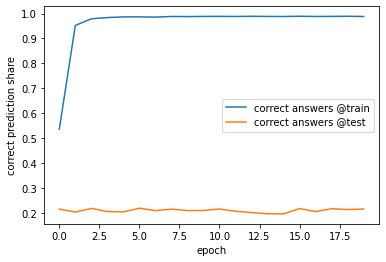

In [ ]:
modelD = Sequential()
modelD.add(Dense(
    100, 
    input_dim = maxWordsCount,
    activation = 'relu'
))
modelD.add(Dropout(0.4))
modelD.add(Dense(100, activation='relu'))
modelD.add(Dropout(0.3))
modelD.add(Dense(100, activation='relu'))
modelD.add(Dropout(0.2))
modelD.add(Dense(len(set(labels)), activation='softmax'))

modelD.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

history = modelD.fit(
    xTrainB, yTrain,
    epochs=20,
    batch_size=128,
    validation_data = (xValB, yVal)
)

plt.plot(history.history['accuracy'], label='correct answers @train')
plt.plot(history.history['val_accuracy'], label='correct answers @test')
plt.xlabel('epoch')
plt.ylabel('correct prediction share')
plt.legend()
plt.show()

In [ ]:
def modelPred():
    probs = modelD.predict(xValB)
    preds = [np.argmax(prob) for prob in probs]
    gTrues = [np.argmax(gTrue) for gTrue in yVal]

    correctPred = 0
    for idx in range(len(preds)):
        if preds[idx] == gTrues[idx]:
            correctPred +=1
        
    return f'model score is {round(correctPred / len(preds), 2) * 100} %'

modelPred()

'model score is 22.0 %'

The score is bad. Probably the lower slice length and step will do the trick, but the RAM available to me is not sufficient to perform that.